In [37]:
# reading files 
import os
# matching filenames
import re
import logging

# reading tiffs
import osgeo.gdal
# computation
import numpy as np
# tables
import pandas as pd 

# segmentation
import skimage.segmentation

# plotting
import matplotlib.style
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read from this directory
datadir = '/Users/baart_f/data/landsat/zm'

# match the filename with this pattern
pattern = re.compile(r'^all\-(?P<date>\d+\-\d+\-\d+)\.(?P<channel>[\w\d]+)\.tif$')

# loop over all the files
files = []
for f in os.listdir(datadir):
    match = pattern.match(f)
    if match:
        record = match.groupdict()
        record['file'] = f
        files.append(record)
df = pd.DataFrame.from_records(files)
# ignore the temp and BQA channels
table = df[~np.in1d(df.channel, ('temp', 'BQA'))].pivot(index='channel', columns='date')
# these are the files we'll process
table

file                            \
date                   2013-07-19                2013-08-04   
channel                                                       
blue      all-2013-07-19.blue.tif   all-2013-08-04.blue.tif   
blue2    all-2013-07-19.blue2.tif  all-2013-08-04.blue2.tif   
green    all-2013-07-19.green.tif  all-2013-08-04.green.tif   
nir        all-2013-07-19.nir.tif    all-2013-08-04.nir.tif   
pan        all-2013-07-19.pan.tif    all-2013-08-04.pan.tif   
red        all-2013-07-19.red.tif    all-2013-08-04.red.tif   
swir1    all-2013-07-19.swir1.tif  all-2013-08-04.swir1.tif   
swir2    all-2013-07-19.swir2.tif  all-2013-08-04.swir2.tif   

                                                             \
date                   2013-08-13                2013-08-20   
channel                                                       
blue      all-2013-08-13.blue.tif   all-2013-08-20.blue.tif   
blue2    all-2013-08-13.blue2.tif  all-2013-08-20.blue2.tif   
green    all-2013-08-13.green.tif  all-2013-08-20.green.tif   
nir        all-2013-08-13.nir.tif    all-2013-08-20.nir.tif   
pan        all-2013-08-13.pan.tif    all-2013-08-20.pan.tif   
red        all-2013-08-13.red.tif    all-2013-08-20.red.tif   
swir1    all-2013-08-13.swir1.tif  all-2013-08-20.swir1.tif   
swir2    all-2013-08-13.swir2.tif  all-2013-08-20.swir2.tif   

                                                             \
date                   2013-09-05                2013-09-30   
channel                                                       
blue      all-2013-09-05.blue.tif   all-2013-09-30.blue.tif   
blue2    all-2013-09-05.blue2.tif  all-2013-09-30.blue2.tif   
green    all-2013-09-05.green.tif  all-2013-09-30.green.tif   
nir        all-2013-09-05.nir.tif    all-2013-09-30.nir.tif   
pan        all-2013-09-05.pan.tif    all-2013-09-30.pan.tif   
red        all-2013-09-05.red.tif    all-2013-09-30.red.tif   
swir1    all-2013-09-05.swir1.tif  all-2013-09-30.swir1.tif   
swir2    all-2013-09-05.swir2.tif  all-2013-09-30.swir2.tif   

                                                             \
date                   2013-10-07                2013-12-03   
channel                                                       
blue      all-2013-10-07.blue.tif   all-2013-12-03.blue.tif   
blue2    all-2013-10-07.blue2.tif  all-2013-12-03.blue2.tif   
green    all-2013-10-07.green.tif  all-2013-12-03.green.tif   
nir        all-2013-10-07.nir.tif    all-2013-12-03.nir.tif   
pan        all-2013-10-07.pan.tif    all-2013-12-03.pan.tif   
red        all-2013-10-07.red.tif    all-2013-12-03.red.tif   
swir1    all-2013-10-07.swir1.tif  all-2013-12-03.swir1.tif   
swir2    all-2013-10-07.swir2.tif  all-2013-12-03.swir2.tif   

                                                             \
date                   2013-12-10                2013-12-19   
channel                                                       
blue      all-2013-12-10.blue.tif   all-2013-12-19.blue.tif   
blue2    all-2013-12-10.blue2.tif  all-2013-12-19.blue2.tif   
green    all-2013-12-10.green.tif  all-2013-12-19.green.tif   
nir        all-2013-12-10.nir.tif    all-2013-12-19.nir.tif   
pan        all-2013-12-10.pan.tif    all-2013-12-19.pan.tif   
red        all-2013-12-10.red.tif    all-2013-12-19.red.tif   
swir1    all-2013-12-10.swir1.tif  all-2013-12-19.swir1.tif   
swir2    all-2013-12-10.swir2.tif  all-2013-12-19.swir2.tif   

                   ...                                       \
date               ...                           2014-08-23   
channel            ...                                        
blue               ...              all-2014-08-23.blue.tif   
blue2              ...             all-2014-08-23.blue2.tif   
green              ...             all-2014-08-23.green.tif   
nir                ...               all-2014-08-23.nir.tif   
pan                ...               all-2014-08-23.pan.tif   
red                ...               all-2014-08-23.red

In [3]:
# recompute to 0-1
def normalize(arr):
    """normalize to 0-1.0"""
    arr = arr.astype('float64')
    return (arr - arr.min())/(arr.max() - arr.min())

# loop over all the bands, group by date and channel
allbands = []
for channel, row in table.iterrows():
    bands = []
    for date in table['file'].columns:
        filename = row['file'][date]
        ds = osgeo.gdal.Open(os.path.join(datadir, filename))
        band = ds.ReadAsArray(0)
        bands.append(normalize(band))
    # add an extra channel to the end for the time     
    allbands.append(np.dstack(bands)[:,:,:,np.newaxis])
# concatenate everything into 1 array    
data = np.concatenate(allbands, axis=-1)
# should be in the shape of space x time x channels 
# time is just another spatial dimension for the segmentation
data.shape

(591, 971, 35, 8)

In [4]:
# segment all the images, it seems to convert floats back to ints, so we'll multiply with 255, check what's going on....
# We're using multichannels (n=8), no lab space as we don't have rgb
# n_segments should be quite large otherwise slic connectivity will force superpixels in first and last images together
# distances in time are 10x distance in space. TODO: compute variance in time and space and choose something more sophisticated. 
labels = skimage.segmentation.slic(
        (data*255.0), 
        multichannel=True, 
        convert2lab=False, 
        n_segments=200*35, 
        enforce_connectivity=True, 
        spacing=(1,1,10.0)
)
# we should have labels in space x time
labels.shape

(591, 971, 35)

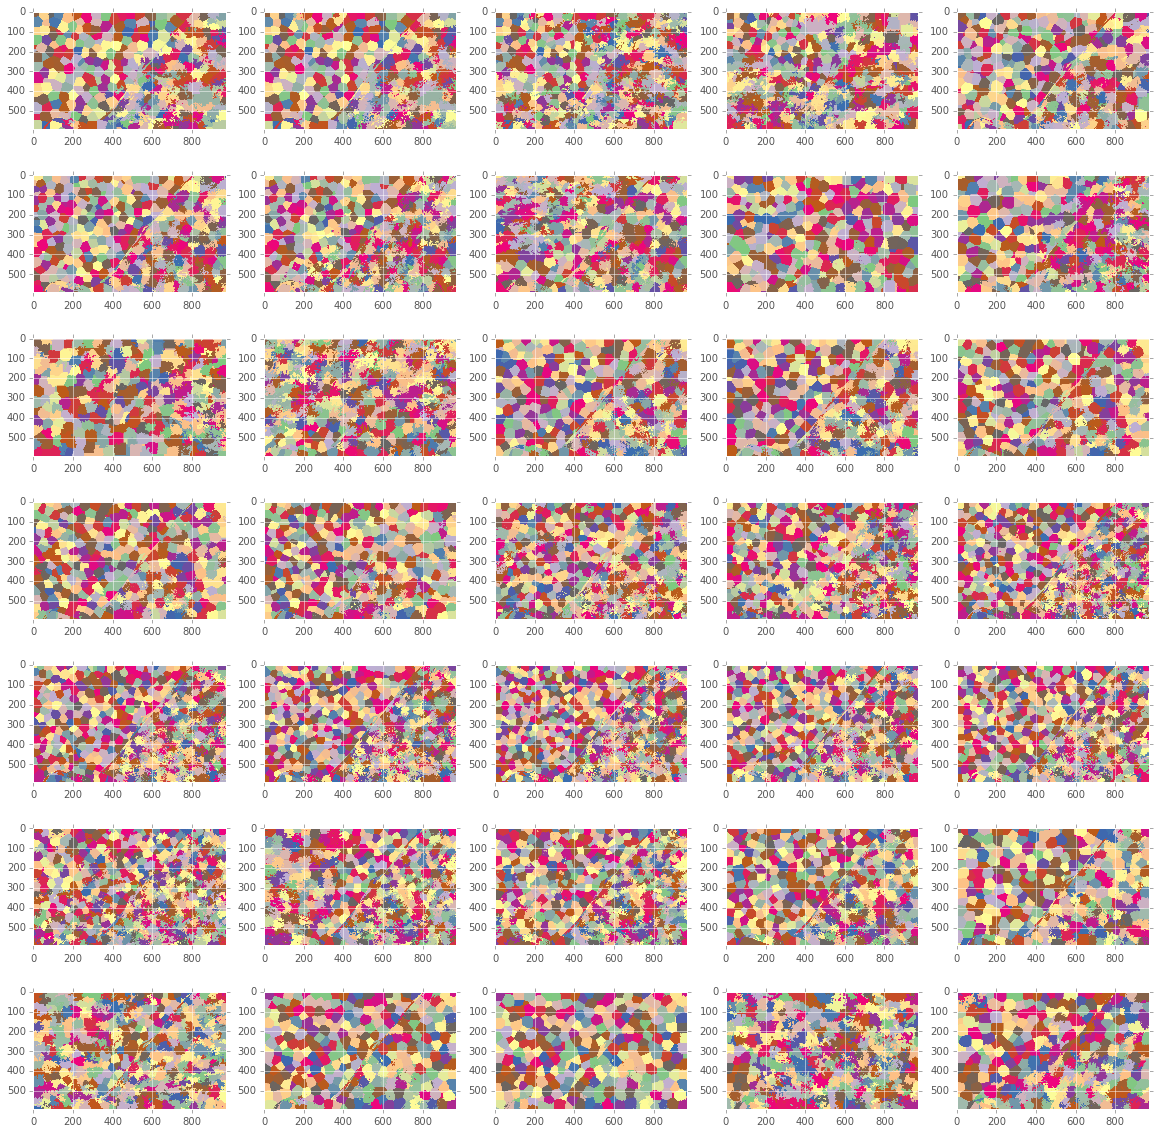

In [11]:
# plot the segments
fig, axes = plt.subplots(7, 5, figsize=(20, 20))
colors = np.arange(labels.max())
# shuffle the colors so we see some patterns
np.random.shuffle(colors)
# this should show a homogenous distribution over time and space
for i, ax in enumerate(axes.flat):
    ax.imshow(colors[labels[:,:,i]-1], cmap='Accent')


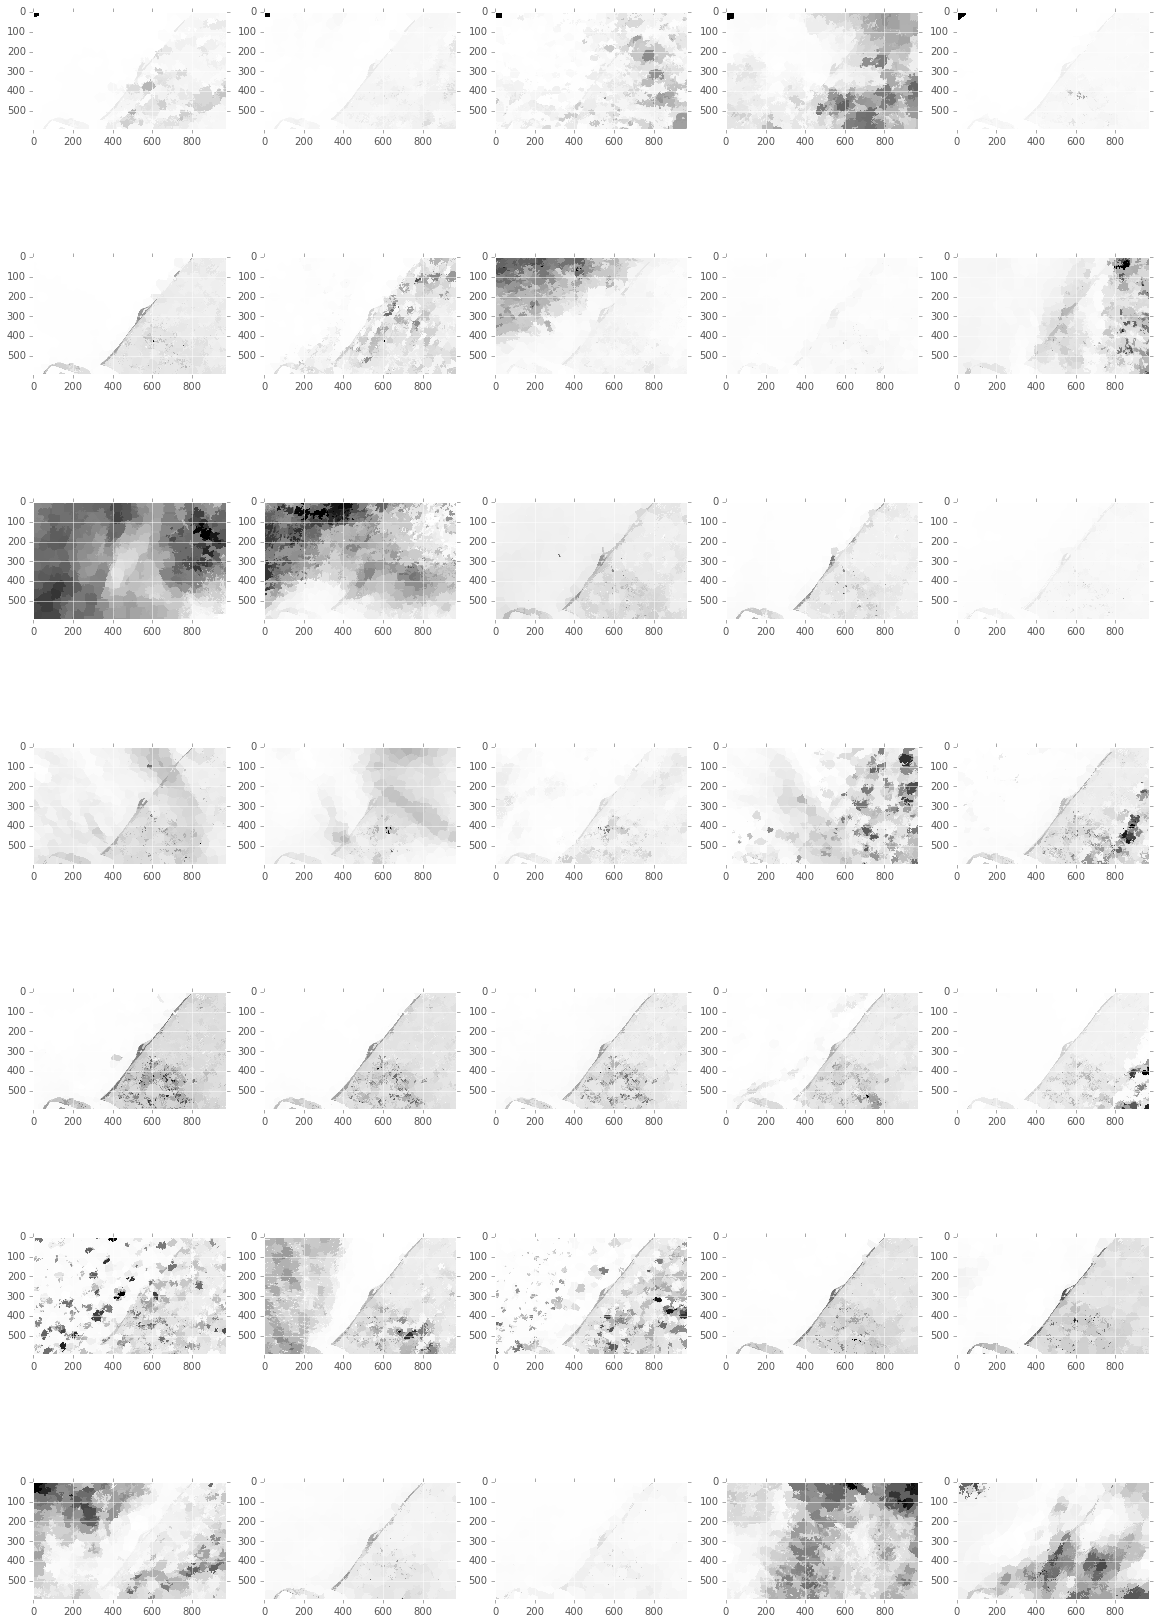

In [40]:
# now plot the segments with mean intensities to see if we're detecting the sand engine and coastline

fig, axes = plt.subplots(7,5, figsize=(20,30))
# create a list of properties
plist = [None for i in range(labels.max() + 1)]

# loop over all times
for i, ax in enumerate(axes.flat):
    # compute the mean intensity
    properties = skimage.measure.regionprops(labels[...,i], intensity_image=data[:,:,i].mean(-1))
    # store the properties
    for p in properties:
        plist[p.label] = p
    # store the mean intensity
    intensity = np.array([p.mean_intensity if p is not None else 1.0 for p in plist ])
    # plot the intensities
    ax.imshow(intensity[labels[...,i]], cmap='Greys')
# something wrong in the first pixel...., TODO: check label 0 based or 1 based....